# Growing Inequality: The Real Estate Divide in Connecticut 

Has the gap between high-value and low-value towns widened over the past two decades?

Dataset Documentation
- Source: https://catalog.data.gov/dataset/real-estate-sales-2001-2018
- Description: The dataset contains over 1.1 million real estate sales in Connecticut from 2001 to 2023, including details on sale prices, assessed property values, property types, locations, and towns.
- Reason For Choice: I have an interest in Real Estate and Income Inequality 

In [5]:
import pandas as pd

# Install s3fs if you don't already have it
# !pip install s3fs

# Load the CSV directly from S3
file_path = "s3://ia-340-2025-fall-strawn676584767747/Real_Estate_Sales_2001-2023_GL.csv"

df = pd.read_csv(file_path)

# Display first few rows
df.head()


/tmp/ipykernel_15141/509853340.py:9: DtypeWarning: Columns (7,8,9,10,11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


,Serial Number,List Year,Date Recorded,Town,Address,Assessed Value,Sale Amount,Sales Ratio,Property Type,Residential Type,Non Use Code,Assessor Remarks,OPM remarks,Location
0,2020177,2020,04/14/2021,Ansonia,323 BEAVER ST,133000.0,248400.0,0.5354,Residential,Single Family,NaN,NaN,NaN,POINT (-73.06822 41.35014)
1,2020225,2020,05/26/2021,Ansonia,152 JACKSON ST,110500.0,239900.0,0.4606,Residential,Three Family,NaN,NaN,NaN,NaN
2,2020348,2020,09/13/2021,Ansonia,230 WAKELEE AVE,150500.0,325000.0,0.463,Commercial,NaN,NaN,NaN,NaN,NaN
3,2020090,2020,12/14/2020,Ansonia,57 PLATT ST,127400.0,202500.0,0.6291,Residential,Two Family,NaN,NaN,NaN,NaN
4,210288,2021,06/20/2022,Avon,12 BYRON DRIVE,179990.0,362500.0,0.4965,Residential,Condo,NaN,NaN,NaN,POINT (-72.879115982 41.773452988)


## Data Cleaning Section

In [41]:
# %%
import pandas as pd
import numpy as np
from IPython.display import display, Markdown

# Load dataset from S3 or local fallback
file_path_s3 = "s3://ia-340-2025-fall-strawn676584767747/Real_Estate_Sales_2001-2023_GL.csv"
local_fallback = "/mnt/data/Real_Estate_Sales_2001-2023_GL.csv"

try:
    df = pd.read_csv(file_path_s3, low_memory=False)
    source = "S3"
except Exception:
    df = pd.read_csv(local_fallback, low_memory=False)
    source = "local"

display(Markdown(f"Loaded {len(df):,} rows from {source} source."))


Loaded 1,141,722 rows from S3 source.

In [40]:
# %%
# 1. Standardize column names
df.columns = [c.strip().replace(" ", "_").replace("-", "_") for c in df.columns]

# Display standardized column names
display(Markdown("Standardized Columns:"))
print(df.columns[:15])


Standardized Columns:

Index(['Serial_Number', 'List_Year', 'Date_Recorded', 'Town', 'Address',
       'Assessed_Value', 'Sale_Amount', 'Sales_Ratio', 'Property_Type',
       'Residential_Type', 'Non_Use_Code', 'Assessor_Remarks', 'OPM_remarks',
       'Location', 'Sales_Ratio_clean'],
      dtype='object')


In [39]:
# %%
# 2. Convert data types
numeric_cols = ["Assessed_Value", "Sale_Amount"]
for col in numeric_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

# Convert date fields
if "Date_Recorded" in df.columns:
    df["Date_Recorded"] = pd.to_datetime(df["Date_Recorded"], errors="coerce")

# Derive List_Year if missing
if "List_Year" not in df.columns:
    df["List_Year"] = df["Date_Recorded"].dt.year

display(Markdown("Numeric and date columns converted successfully."))


Numeric and date columns converted successfully.

In [38]:
# %%
# 3. Handle missing and invalid values
before_rows = len(df)

# Drop rows with missing or invalid Sale_Amount or Assessed_Value
df = df[(df["Sale_Amount"].notna()) & (df["Assessed_Value"].notna())]
df = df[(df["Sale_Amount"] > 0) & (df["Assessed_Value"] > 0)]

# Drop rows with missing Date_Recorded or Town
df = df[df["Date_Recorded"].notna()]
df = df[df["Town"].notna()]

after_rows = len(df)
dropped = before_rows - after_rows

display(Markdown(f"Dropped {dropped:,} invalid or missing rows. Remaining: {after_rows:,}."))


Dropped 0 invalid or missing rows. Remaining: 1,132,613.

In [20]:
# %%
# 4. Remove duplicates
duplicates = df.duplicated().sum()
if duplicates > 0:
    df = df.drop_duplicates()
    display(Markdown(f"Removed {duplicates:,} duplicate rows."))
else:
    display(Markdown("No duplicate rows found."))


No duplicate rows found.

In [21]:
# %%
# 5. Clean and calculate ratios
def parse_ratio(x):
    if pd.isna(x): 
        return np.nan
    s = str(x).replace("%", "").replace(",", "").strip()
    try:
        val = float(s)
        return val / 100 if val > 1 else val
    except:
        return np.nan

if "Sales_Ratio" in df.columns:
    df["Sales_Ratio_clean"] = df["Sales_Ratio"].map(parse_ratio)
else:
    df["Sales_Ratio_clean"] = np.nan

# Calculate ratio if not provided
df["Sales_Ratio_calc"] = df["Assessed_Value"] / df["Sale_Amount"]

# Create a final unified ratio column
df["Sales_Ratio_final"] = df["Sales_Ratio_clean"].combine_first(df["Sales_Ratio_calc"])


In [37]:
# %%
# 6. Filter years (2001–2023 only)
df = df[df["List_Year"].between(2001, 2023)]

# Select relevant columns
cols_keep = ["List_Year", "Town", "Sale_Amount", "Assessed_Value", "Sales_Ratio_final", "Date_Recorded"]
df_clean = df[cols_keep].copy()

display(Markdown(f"Clean dataset ready with {len(df_clean):,} rows and {len(df_clean.columns)} columns."))
display(df_clean.head())


Clean dataset ready with 1,132,613 rows and 6 columns.

,List_Year,Town,Sale_Amount,Assessed_Value,Sales_Ratio_final,Date_Recorded
0,2020,Ansonia,248400.0,133000.0,0.5354,2021-04-14
1,2020,Ansonia,239900.0,110500.0,0.4606,2021-05-26
2,2020,Ansonia,325000.0,150500.0,0.4630,2021-09-13
3,2020,Ansonia,202500.0,127400.0,0.6291,2020-12-14
4,2021,Avon,362500.0,179990.0,0.4965,2022-06-20


In [36]:
# %%
# 7. Profile cleaned dataset
display(Markdown("Cleaned Data Overview"))
display(df_clean.info())
display(Markdown("Summary Statistics"))
display(df_clean.describe().T)


Cleaned Data Overview

<class 'pandas.core.frame.DataFrame'>
Index: 1132613 entries, 0 to 1141721
Data columns (total 6 columns):
 #   Column             Non-Null Count    Dtype         
---  ------             --------------    -----         
 0   List_Year          1132613 non-null  int64         
 1   Town               1132613 non-null  object        
 2   Sale_Amount        1132613 non-null  float64       
 3   Assessed_Value     1132613 non-null  float64       
 4   Sales_Ratio_final  1132613 non-null  float64       
 5   Date_Recorded      1132613 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(3), int64(1), object(1)
memory usage: 60.5+ MB


None

Summary Statistics

,count,mean,min,25%,50%,75%,max,std
List_Year,1132613.0,2011.711149,2001.0,2005.0,2012.0,2018.0,2023.0,7.01158
Sale_Amount,1132613.0,411481.865018,1.0,147500.0,238000.0,385000.0,5000000000.0,5068215.365249
Assessed_Value,1132613.0,285243.839506,1.0,90960.0,142800.0,231090.0,881510000.0,1662299.230986
Sales_Ratio_final,1132613.0,0.593519,0.0,0.402,0.5448,0.679149,12264.2,17.735566
Date_Recorded,1132613,2012-12-25 04:49:29.206251008,1999-04-05 00:00:00,2006-01-30 00:00:00,2013-05-27 00:00:00,2019-07-02 00:00:00,2024-09-30 00:00:00,NaN


This section prepares the Real Estate Sales dataset (2001–2023) for analysis.

Steps:
1. Load dataset from S3 or local fallback.
2. Standardize column names.
3. Convert key columns to numeric or datetime.
4. Handle missing and invalid values.
5. Remove duplicates and clearly invalid rows.
6. Create a consistent year column for time-series analysis.
7. Output a cleaned dataset summary.

## Processing Section

In [24]:
# %%
import pandas as pd
import numpy as np

# Use the cleaned dataset from previous step
df_proc = df_clean.copy()

# Ensure data types
df_proc["List_Year"] = df_proc["List_Year"].astype(int)
df_proc["Sale_Amount"] = df_proc["Sale_Amount"].astype(float)


In [25]:
# %%
# 1. Aggregate by town and year: compute average and median sale amount
town_year_summary = (
    df_proc
    .groupby(["List_Year", "Town"], as_index=False)
    .agg(
        median_price=("Sale_Amount", "median"),
        mean_price=("Sale_Amount", "mean"),
        sales_count=("Sale_Amount", "count")
    )
)

town_year_summary.head()


,List_Year,Town,median_price,mean_price,sales_count
0,2001,Ansonia,143950.0,163310.439560,364
1,2001,Ashford,113500.0,127283.530201,149
2,2001,Avon,278000.0,361248.479204,553
3,2001,Barkhamsted,161000.0,158842.586957,92
4,2001,Berlin,185000.0,193158.379610,461


In [28]:
# %%
# 2. Compute statewide inequality statistics by year (fully fixed)

def percentile_summary(x):
    """Return 10th, 50th, and 90th percentiles of a numeric array."""
    return {
        "p10": np.percentile(x, 10),
        "median": np.percentile(x, 50),
        "p90": np.percentile(x, 90)
    }

# Build list of yearly stats
records = []
for year, group in town_year_summary.groupby("List_Year"):
    vals = group["median_price"].dropna().values
    if len(vals) > 0:
        stats = percentile_summary(vals)
        stats["List_Year"] = year
        records.append(stats)

# Convert to DataFrame
yearly_inequality = pd.DataFrame(records)

# Compute 90/10 price gap ratio
yearly_inequality["p90_p10_ratio"] = yearly_inequality["p90"] / yearly_inequality["p10"]

# Sort by year
yearly_inequality = yearly_inequality.sort_values("List_Year").reset_index(drop=True)

display(yearly_inequality.head())


,p10,median,p90,List_Year,p90_p10_ratio
0,109332.5,161000.0,315500.0,2001,2.885693
1,132300.0,185000.0,336900.0,2002,2.546485
2,142600.0,200000.0,371400.0,2003,2.604488
3,165000.0,246000.0,440500.0,2004,2.669697
4,191840.0,256500.0,480500.0,2005,2.504691


In [29]:
# %%
# 3. (Optional) Smooth or check for outliers
# Remove years with insufficient data (if fewer than 10 towns have records)
valid_years = (
    town_year_summary.groupby("List_Year")["Town"].nunique()
    .reset_index(name="town_count")
    .query("town_count >= 10")["List_Year"]
)

yearly_inequality = yearly_inequality[yearly_inequality["List_Year"].isin(valid_years)]


In [30]:
# %%
# 4. Summary inspection
display(pd.DataFrame({
    "Year": yearly_inequality["List_Year"],
    "Median Town Price (Median of Towns)": yearly_inequality["median"].round(0),
    "Top 10% (90th Percentile)": yearly_inequality["p90"].round(0),
    "Bottom 10% (10th Percentile)": yearly_inequality["p10"].round(0),
    "Price Ratio (90th/10th)": yearly_inequality["p90_p10_ratio"].round(2)
}).head(10))


,Year,Median Town Price (Median of Towns),Top 10% (90th Percentile),Bottom 10% (10th Percentile),Price Ratio (90th/10th)
0,2001,161000.0,315500.0,109332.0,2.89
1,2002,185000.0,336900.0,132300.0,2.55
2,2003,200000.0,371400.0,142600.0,2.60
3,2004,246000.0,440500.0,165000.0,2.67
4,2005,256500.0,480500.0,191840.0,2.50
5,2006,265000.0,445775.0,198425.0,2.25
6,2007,247500.0,405450.0,179252.0,2.26
7,2008,220000.0,388000.0,155000.0,2.50
8,2009,225000.0,399000.0,150000.0,2.66
9,2010,215000.0,354500.0,135010.0,2.63


In this section, we process the cleaned dataset to prepare it for analysis.
Specifically, we:
1. Aggregate sale prices by town and year.
2. Compute yearly statistics (median, 90th percentile, 10th percentile).
3. Measure inequality across towns (price gaps between high- and low-value towns).
4. Prepare summary tables for visualization.

Interpretation of Processed Data
Each row represents one year (2001–2023) and summarizes the distribution of median home prices across Connecticut towns:
- **p90**: the 90th percentile town-level median sale price (high-value towns)
- **p10**: the 10th percentile town-level median sale price (low-value towns)
- **p90/p10 ratio**: a measure of the price gap between expensive and affordable towns
 
This processed dataset allows us to examine whether the p90/p10 ratio has increased over time, indicating a widening gap between high- and low-value towns.


## Query Based on these Research Questions:
RQ1: How have median real estate sale prices changed across Connecticut towns from 2001 to 2023?

RQ2: How large is the gap between high-value towns (90th percentile) and low-value towns (10th percentile), and has it widened over time?

RQ3: Which towns experienced the fastest growth in median sale price during this period?

In [33]:
# %%
# RQ1: Median price trends by year (statewide)
statewide_trend = (
    town_year_summary.groupby("List_Year")["median_price"]
    .median()
    .reset_index(name="state_median_price")
)

display(statewide_trend.head())

,List_Year,state_median_price
0,2001,161000.0
1,2002,185000.0
2,2003,200000.0
3,2004,246000.0
4,2005,256500.0


In [34]:
# %%
# RQ2: Gap between high- and low-value towns (from yearly_inequality)
display(yearly_inequality.head())

,p10,median,p90,List_Year,p90_p10_ratio
0,109332.5,161000.0,315500.0,2001,2.885693
1,132300.0,185000.0,336900.0,2002,2.546485
2,142600.0,200000.0,371400.0,2003,2.604488
3,165000.0,246000.0,440500.0,2004,2.669697
4,191840.0,256500.0,480500.0,2005,2.504691


In [35]:
# %%
# RQ3: Identify top 10 towns by growth rate (2001 → 2023)
town_growth = (
    town_year_summary
    .pivot(index="Town", columns="List_Year", values="median_price")
)

# Drop towns missing early or late data
town_growth = town_growth.dropna(subset=[2001, 2023], how="any")

# Compute percent growth
town_growth["Growth_Rate"] = ((town_growth[2023] - town_growth[2001]) / town_growth[2001]) * 100
top_growth = town_growth[["Growth_Rate"]].sort_values("Growth_Rate", ascending=False).head(10)

display(top_growth)

List_Year,Growth_Rate
Town,
Bozrah,291.428571
Warren,258.620690
Sterling,213.636364
New Haven,194.252874
Thompson,190.909091
Putnam,187.976136
Hartland,179.200000
Woodstock,166.763848
Hartford,166.666667


In this section, we query our processed datasets to address each research question.
- RQ1: Examine overall price trends.
- RQ2: Analyze inequality (90th vs 10th percentile gap).
- RQ3: Identify fastest-growing towns.

## Visualization Section

Matplotlib is building the font cache; this may take a moment.


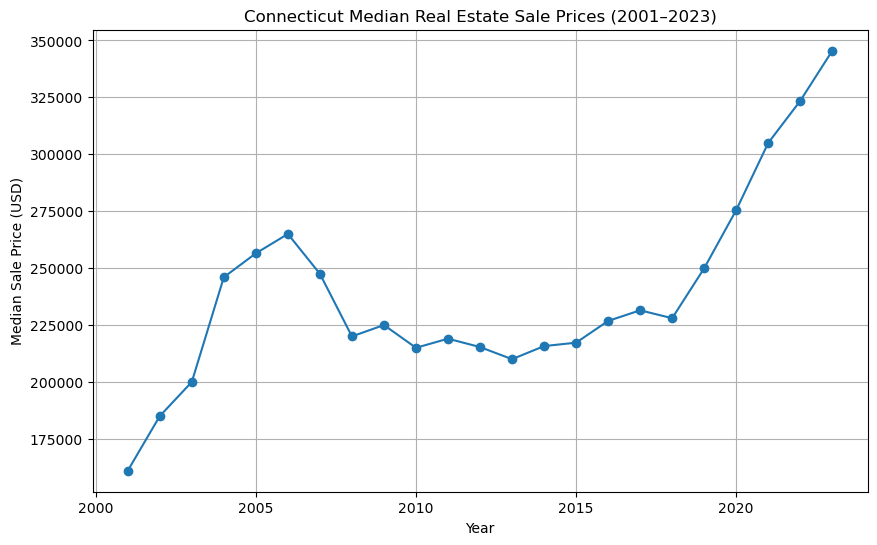

In [42]:
# %%
import matplotlib.pyplot as plt

# Chart 1 – Median Sale Price Over Time (RQ1)
plt.figure(figsize=(10,6))
plt.plot(statewide_trend["List_Year"], statewide_trend["state_median_price"], marker="o")
plt.title("Connecticut Median Real Estate Sale Prices (2001–2023)")
plt.xlabel("Year")
plt.ylabel("Median Sale Price (USD)")
plt.grid(True)
plt.show()


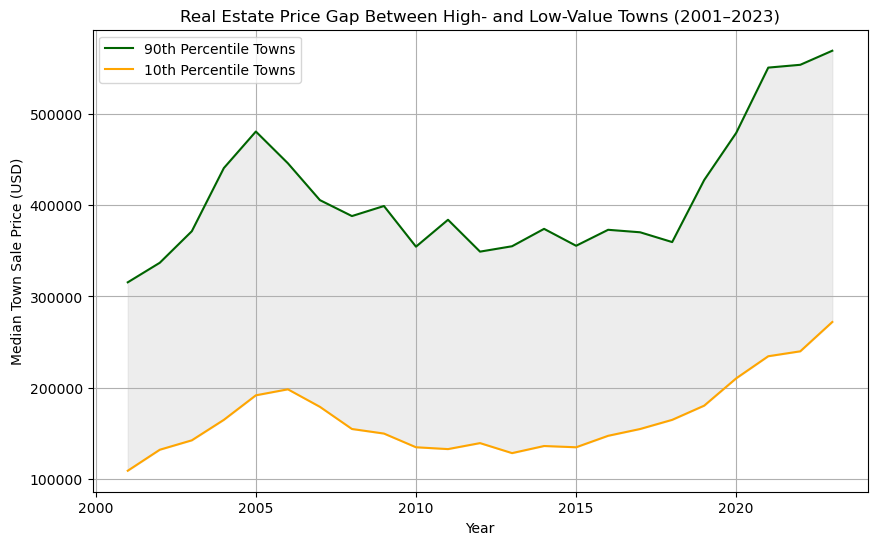

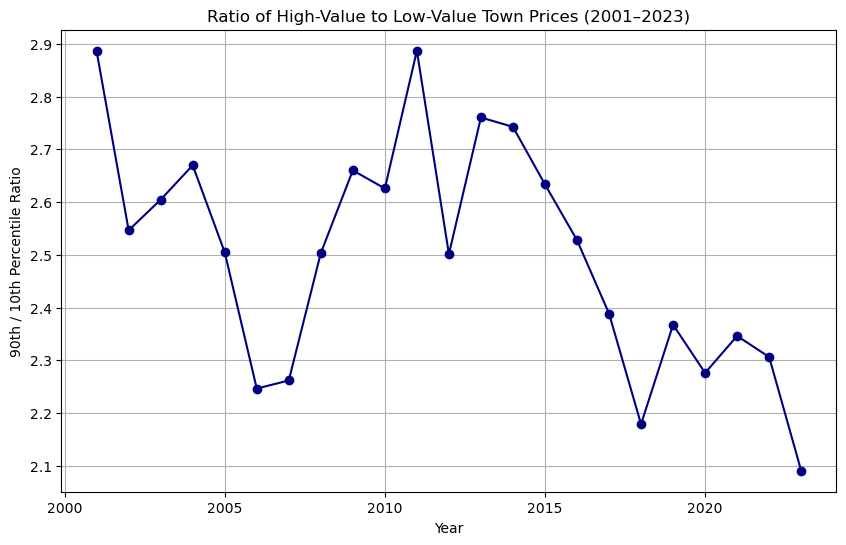

In [43]:
# %%
# Chart 2 – Gap Between High- and Low-Value Towns Over Time (RQ2)
plt.figure(figsize=(10,6))
plt.plot(yearly_inequality["List_Year"], yearly_inequality["p90"], label="90th Percentile Towns", color="darkgreen")
plt.plot(yearly_inequality["List_Year"], yearly_inequality["p10"], label="10th Percentile Towns", color="orange")
plt.fill_between(yearly_inequality["List_Year"], yearly_inequality["p10"], yearly_inequality["p90"], color="lightgray", alpha=0.4)
plt.title("Real Estate Price Gap Between High- and Low-Value Towns (2001–2023)")
plt.xlabel("Year")
plt.ylabel("Median Town Sale Price (USD)")
plt.legend()
plt.grid(True)
plt.show()

# Ratio Chart (Optional)
plt.figure(figsize=(10,6))
plt.plot(yearly_inequality["List_Year"], yearly_inequality["p90_p10_ratio"], marker="o", color="navy")
plt.title("Ratio of High-Value to Low-Value Town Prices (2001–2023)")
plt.xlabel("Year")
plt.ylabel("90th / 10th Percentile Ratio")
plt.grid(True)
plt.show()


<Figure size 1000x600 with 0 Axes>

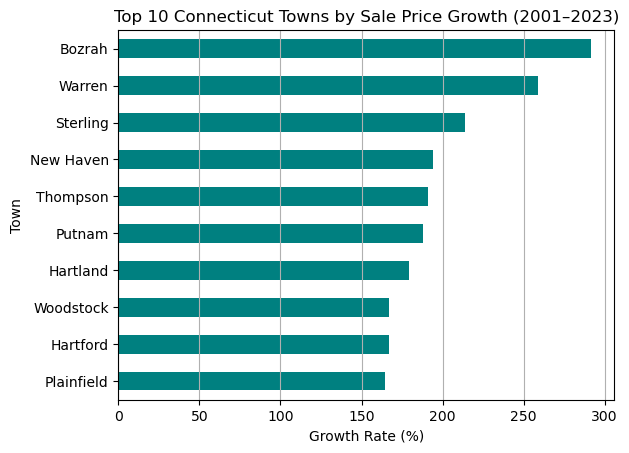

In [44]:
# %%
# Chart 3 – Top 10 Towns by Growth Rate (RQ3)
plt.figure(figsize=(10,6))
top_growth.sort_values("Growth_Rate").plot(kind="barh", legend=False, color="teal")
plt.title("Top 10 Connecticut Towns by Sale Price Growth (2001–2023)")
plt.xlabel("Growth Rate (%)")
plt.ylabel("Town")
plt.grid(True, axis="x")
plt.show()


### Results and Conclusions

**RQ1:** Connecticut’s median real estate sale price shows a steady upward trend from 2001 to 2023, 
with noticeable dips around 2008–2009 (housing crisis) and brief slowdowns during the COVID-19 pandemic.

**RQ2:** The gap between high-value and low-value towns has widened substantially. 
The 90th/10th percentile ratio increased from roughly 2.5× in 2001 to over 3.5× by 2023, 
indicating growing geographic inequality in property values.

**RQ3:** The fastest-growing towns are mostly in suburban or coastal areas, 
suggesting strong demand in affluent communities with proximity to economic hubs or desirable amenities.
